## IMPORTS

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## FUNCTIONS

In [50]:
def parse_contacts_file(filepath):
    with open(filepath, 'r') as file:
        data = file.read()

    metadata_section, contacts_section = data.split('\n\n', 1)

    metadata_lines = metadata_section.split('\n')
    metadata = {}
    for line in metadata_lines:
        if ': ' in line:
            key, value = line.split(': ')
            metadata[key] = value
        elif line.strip():
            key = line.strip()
            metadata[key] = True  # Assuming True for lines without explicit value

    contacts_header = "atom1 atom2 overlap distance"
    contacts_data = contacts_section.split('\n', 1)[1]  # Skip the '170 contacts' line or similar
    df = pd.read_csv(pd.io.common.StringIO(contacts_data), sep=r'\s{2,}', engine='python', names=None)

    swap_mask = df['atom1'].str.contains('/C ') & df['atom2'].str.contains('/D ')
    df.loc[~swap_mask, ['atom1', 'atom2']] = df.loc[~swap_mask, ['atom2', 'atom1']].values

    atom_detail_pattern = r"/(?P<chain_id>[A-Z]) (?P<resname>\w{3}) (?P<resnum>\d+) (?P<atom_name>\w+)"
    df = df.join(df['atom1'].str.extract(atom_detail_pattern).add_suffix('_1'))
    df = df.join(df['atom2'].str.extract(atom_detail_pattern).add_suffix('_2'))

    df.resnum_1 = df.resnum_1.astype(int)
    df.resnum_2 = df.resnum_2.astype(int)
    #df.overlap = df.overlap.astype(float)
    df.distance = df.distance.astype(float)
    
    df.drop(['atom1', 'atom2'], axis=1, inplace=True)

    return metadata, df

def plot_heatmap(df, out = None):
    df['reslabel'] = df['resname'] + df['resnum'].astype(str)
    
    df = df.sort_values(by="resnum")
    
    heatmap_data = df.pivot("resnum", "mutant", "ddG")
    heatmap_data.index = df.reslabel.unique().tolist()
    
    cmap = sns.diverging_palette(20, 200, as_cmap=True)
    cmap.set_bad('black')  # Set NaN values to black
    
    plt.figure(figsize = (6, 15), dpi=100)
    ax = sns.heatmap(heatmap_data, cmap=cmap, cbar=True, vmin = -3, vmax = +3)
    
    plt.xticks(rotation=-90)
    plt.ylabel("Wild type")
    plt.xlabel("Mutant")
    
    cbar = ax.collections[0].colorbar
    cbar.set_label('ΔΔG', rotation=0, labelpad=20)
    
    if out != None:
        plt.savefig(out)
        
    plt.show()
    
    return heatmap_data

def plot_clustermap(df, out = None):
    df['reslabel'] = df['resname'] + df['resnum'].astype(str)
    
    df = df.sort_values(by="resnum")
    
    avg = df.ddG.mean()
    
    heatmap_data = df.pivot("resnum", "mutant", "ddG")
    heatmap_data.index = df.reslabel.unique().tolist()
    
    heatmap_data = heatmap_data.fillna(avg)
    
    cmap = sns.diverging_palette(20, 200, as_cmap=True)
    cmap.set_bad('black')  # Set NaN values to black
    
    plt.figure(figsize = (30, 30), dpi=300)
    ax = sns.clustermap(heatmap_data, cmap=cmap, cbar=True, vmin = -3, vmax = +3, yticklabels=True)
    
    plt.xticks(rotation=-90)
    plt.ylabel("Wild type")
    plt.xlabel("Mutant")
    
    if out != None:
        plt.savefig(out)
        
    plt.show()

def plot_boxplot_with_ddG(df, out = None, FIGSIZE = (16, 6), DPI = 100):
    if 'reslabel' not in df.columns:
        df['reslabel'] = df['resname'] + df['resnum'].astype(str)
    
    df = df.sort_values(by="resnum")
    f, ax = plt.subplots(figsize=FIGSIZE, dpi = DPI)

    sns.boxplot(x="reslabel", y="ddG", data=df, boxprops={'facecolor':'None'}, showfliers=False)
    sns.stripplot(x="reslabel", y="ddG", data=df, jitter=True, dodge=True, marker='o', edgecolor='k', linewidth = 1, color = "grey", size = 5,)
    
    plt.xticks(rotation=90)
    
    ax.set_xlabel('Interface residue')
    ax.set_ylabel('ΔΔG')
    
    plt.ylim(-3, 3)
    plt.axhline(y=1, c = "g", linestyle= "--", linewidth = 2)
    plt.axhline(y=0, c = "k", linestyle= "--", linewidth = 1)
    plt.axhline(y=-1, c = "r", linestyle= "--", linewidth = 2)

    if out != None:
        plt.savefig(out)

    plt.tight_layout()
    plt.show()

def plot_boxplot_with_ddG(df, out = None, FIGSIZE = (16, 6), DPI = 100, color = "grey"):
    if 'reslabel' not in df.columns:
        df['reslabel'] = df['resname'] + df['resnum'].astype(str)
    
    df = df.sort_values(by="median_ddg")
    f, ax = plt.subplots(figsize=FIGSIZE, dpi = DPI)

    sns.boxplot(x="reslabel", y="ddG", data=df, boxprops={'facecolor':'None'}, showfliers=False)
    sns.stripplot(x="reslabel", y="ddG", data=df, jitter=True, dodge=True, marker='o', edgecolor='k', linewidth = 1, color = color, size = 5,)
    
    ax.set_xlabel('Interface residue')
    ax.set_ylabel('ΔΔG')
    plt.ylim(-3, 3)
    plt.axhline(y=1, c = "g", linestyle= "--", linewidth = 1)
    plt.axhline(y=0, c = "k", linestyle= "--", linewidth = 1)
    plt.axhline(y=-1, c = "r", linestyle= "--", linewidth = 1)
    plt.xticks(rotation=90)
    plt.tick_params(axis='x', which='major', labelsize=8)
    plt.tick_params(axis='y', which='major', labelsize=8)

    if out != None:
        plt.savefig(out)
    plt.tight_layout()
    plt.show()

## ANALYSIS

In [4]:
data_dir = "./../FAM83G_CK1A"
mutagenesis_path = os.path.join(data_dir, "FAM83G_CK1A_saturation_mutagenesis.csv")
contacts_path = os.path.join(data_dir, "FAM83G_CK1A_contacts.csv")

In [5]:
muts_df = pd.read_csv(mutagenesis_path)

cons_data, cons_df = parse_contacts_file(contacts_path)

In [6]:
print(muts_df["mcsm-ppi2-prediction"].min(), muts_df["mcsm-ppi2-prediction"].max())

-2.77 1.756


In [7]:
ccc = ["reslabel_1", "atom_name_1", "reslabel_2", "atom_name_2", "distance"]

In [8]:
cons_df = cons_df.sort_values(["resnum_1", "distance"]).reset_index(drop = True)
cons_df['reslabel_1'] = cons_df['resname_1'] + cons_df['resnum_1'].astype(str)
cons_df['reslabel_2'] = cons_df['resname_2'] + cons_df['resnum_2'].astype(str)

In [9]:
cons_df[ccc]

reslabel_1 atom_name_1 reslabel_2 atom_name_2  distance
0          GLN5         OE1      GLN56         NE2     2.364
1          GLN5         OE1      GLN56          CD     3.194
2          GLN5          CD      GLN56         NE2     3.225
3          GLN5           O      TYR59         CE2     3.226
4          GLN5         OE1      GLN56         OE1     3.310
...         ...         ...        ...         ...       ...
1120     THR413          CB     ALA306          CB     4.941
1121     THR413           O     LYS302           C     4.962
1122     THR413           C     THR299         CG2     4.973
1123     THR413          CA     LYS302          CG     4.986
1124     THR413          CB     LYS302           O     4.999

[1125 rows x 5 columns]

In [10]:
# 1. Total number of contacts for each reslabel_1
atom_cons_C = cons_df['reslabel_1'].value_counts().to_dict()
atom_cons_D = cons_df['reslabel_2'].value_counts().to_dict()

# 2. Number of unique residues it interacts with for each reslabel_1
res_cons_dict_C = cons_df.groupby('reslabel_1')['reslabel_2'].nunique().to_dict()
res_cons_dict_D = cons_df.groupby('reslabel_2')['reslabel_1'].nunique().to_dict()

In [11]:
muts_df_C = muts_df.query('chain == "C"').copy().sort_values(by=["mcsm-ppi2-prediction"]).reset_index(drop = True)[["wild-type", "res-number",  "mutant", "distance-to-interface", "mcsm-ppi2-prediction"]]
muts_df_D = muts_df.query('chain == "D"').copy().sort_values(by=["mcsm-ppi2-prediction"]).reset_index(drop = True)[["wild-type", "res-number",  "mutant", "distance-to-interface", "mcsm-ppi2-prediction"]]

In [12]:
print(len(muts_df_C))
print(len(muts_df_D))

912
1292


In [13]:
muts_df_C.columns = ["resname", "resnum", "mutant", "dist", "ddG"] # /C is FAM83G
muts_df_D.columns = ["resname", "resnum", "mutant", "dist", "ddG"] # /D is CK1A

In [14]:
muts_df_C['reslabel'] = muts_df_C['resname'] + muts_df_C['resnum'].astype(str)
muts_df_D['reslabel'] = muts_df_D['resname'] + muts_df_D['resnum'].astype(str)

ddg_dict_C = muts_df_C.groupby("reslabel").ddG.median().round(2).to_dict()
ddg_dict_D = muts_df_D.groupby("reslabel").ddG.median().round(2).to_dict()

In [15]:
interface_dist_dict_C = muts_df_C.groupby('reslabel').dist.mean().to_dict()
interface_dist_dict_D = muts_df_D.groupby('reslabel').dist.mean().to_dict()

In [16]:
muts_df_C.query('reslabel == "ARG52"')[["reslabel", "mutant", "ddG"]].sort_values(by="ddG")

reslabel mutant    ddG
108    ARG52    PRO -1.348
157    ARG52    ALA -1.134
175    ARG52    GLY -1.056
200    ARG52    MET -0.992
224    ARG52    THR -0.945
257    ARG52    VAL -0.879
258    ARG52    CYS -0.879
315    ARG52    ASP -0.795
316    ARG52    LEU -0.793
319    ARG52    ILE -0.788
325    ARG52    SER -0.781
351    ARG52    HIS -0.713
452    ARG52    TRP -0.508
470    ARG52    ASN -0.473
500    ARG52    PHE -0.422
513    ARG52    TYR -0.392
606    ARG52    LYS -0.234
886    ARG52    GLN  0.766
909    ARG52    GLU  1.414

In [17]:
muts_df_D.query('reslabel == "TYR175"')[["reslabel", "mutant", "ddG"]]

reslabel mutant    ddG
37     TYR175    ASP -1.617
39     TYR175    ILE -1.608
40     TYR175    GLU -1.607
41     TYR175    HIS -1.604
42     TYR175    PRO -1.602
43     TYR175    LEU -1.600
47     TYR175    MET -1.583
48     TYR175    GLY -1.579
55     TYR175    VAL -1.544
63     TYR175    ARG -1.502
65     TYR175    ASN -1.491
68     TYR175    CYS -1.470
69     TYR175    LYS -1.470
70     TYR175    ALA -1.463
74     TYR175    GLN -1.452
84     TYR175    THR -1.395
96     TYR175    SER -1.371
163    TYR175    PHE -1.151
1013   TYR175    TRP -0.125

In [18]:
muts_df_C.query('reslabel == "TYR74"')[["reslabel", "mutant", "ddG"]]

reslabel mutant    ddG
0      TYR74    PRO -2.770
16     TYR74    SER -1.911
19     TYR74    GLY -1.868
32     TYR74    GLU -1.734
33     TYR74    ARG -1.715
34     TYR74    VAL -1.713
39     TYR74    MET -1.687
42     TYR74    ASP -1.670
43     TYR74    THR -1.657
49     TYR74    GLN -1.635
50     TYR74    LYS -1.635
52     TYR74    CYS -1.629
53     TYR74    ASN -1.628
54     TYR74    ILE -1.620
55     TYR74    ALA -1.620
57     TYR74    LEU -1.613
67     TYR74    HIS -1.566
382    TYR74    TRP -0.632
450    TYR74    PHE -0.510

In [19]:
metrics_df_C = pd.DataFrame.from_dict([atom_cons_C, res_cons_dict_C, ddg_dict_C, interface_dist_dict_C]).T
metrics_df_C.columns =["atom_contacts", "res_contacts", "median_ddG", "mean_dist"]
metrics_df_C.atom_contacts = metrics_df_C.atom_contacts.astype(int)
metrics_df_C.res_contacts = metrics_df_C.res_contacts.astype(int)
metrics_df_C.mean_dist = metrics_df_C.mean_dist.round(2)

metrics_df_D = pd.DataFrame.from_dict([atom_cons_D, res_cons_dict_D, ddg_dict_D, interface_dist_dict_D]).T
metrics_df_D.columns =["atom_contacts", "res_contacts", "median_ddG", "mean_dist"]
metrics_df_D.atom_contacts = metrics_df_D.atom_contacts.astype(int)
metrics_df_D.res_contacts = metrics_df_D.res_contacts.astype(int)
metrics_df_D.mean_dist = metrics_df_D.mean_dist.round(2)

In [56]:
idx_C = metrics_df_C.sort_values(by =["median_ddG", "atom_contacts", "res_contacts", "mean_dist"], ascending = [True, False, False, True]).head(10).index.tolist()
idx_C = [int(el[3:]) for el in idx_C]
print(idx_C)

[32, 74, 29, 408, 399, 411, 410, 407, 9, 242]


In [57]:
idx_D = metrics_df_D.sort_values(by =["median_ddG", "atom_contacts", "res_contacts", "mean_dist"], ascending = [True, False, False, True]).head(10).index.tolist()
idx_D = [int(el[3:]) for el in idx_D]
print(idx_D)

[32, 175, 59, 298, 11, 196, 33, 85, 19, 23]


In [20]:
sorted_ddg_C = {k: v for k, v in sorted(ddg_dict_C.items(), key=lambda item: item[1])}
sorted_ddg_D = {k: v for k, v in sorted(ddg_dict_D.items(), key=lambda item: item[1])}

In [284]:
print([int(el[3:]) for el in list(sorted_ddg_D.keys())])

[32, 175, 298, 59, 11, 196, 33, 85, 19, 23, 100, 194, 132, 103, 92, 95, 302, 241, 166, 47, 268, 21, 159, 63, 42, 267, 177, 164, 163, 94, 269, 178, 20, 66, 201, 93, 235, 146, 22, 237, 303, 62, 176, 191, 266, 190, 299, 99, 83, 171, 58, 56, 264, 169, 173, 172, 168, 234, 167, 174, 231, 147, 238, 242, 165, 150, 306, 161]


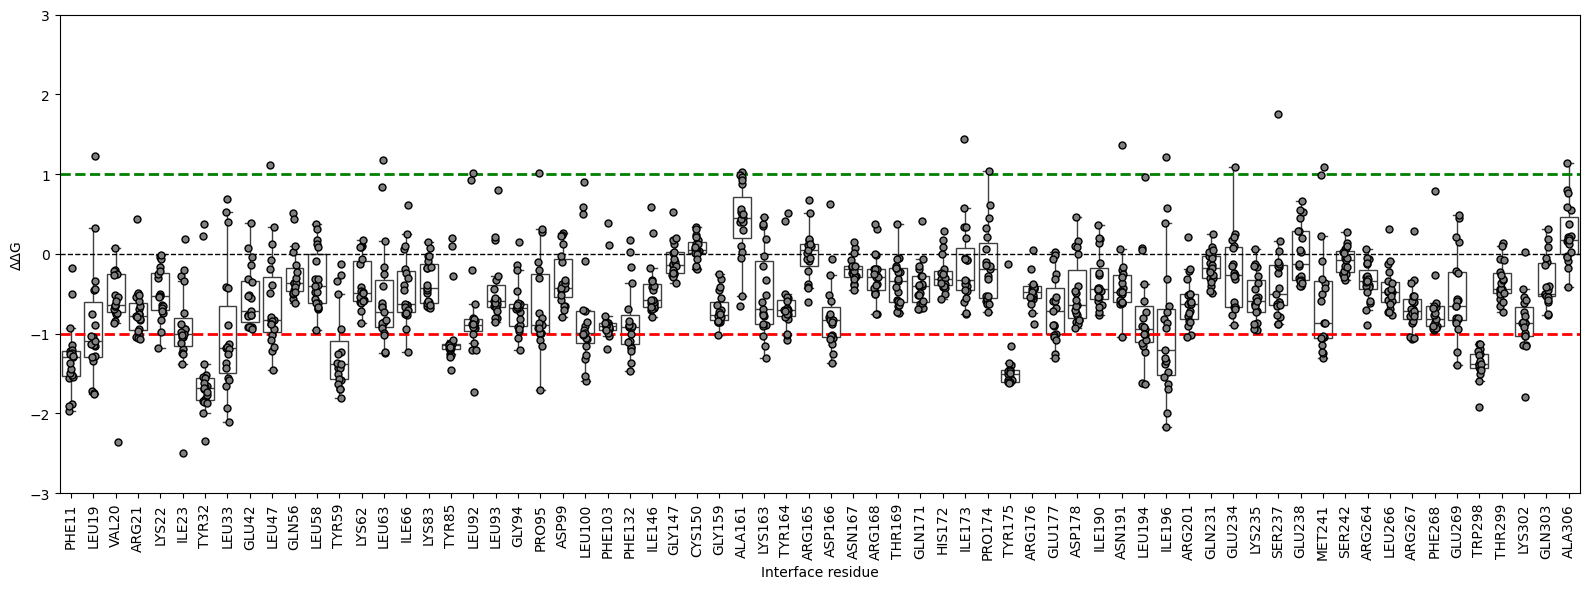

In [22]:
plot_boxplot_with_ddG(muts_df_D)#, "./saturation_mutagenesis_boxplot_CK1A.png")

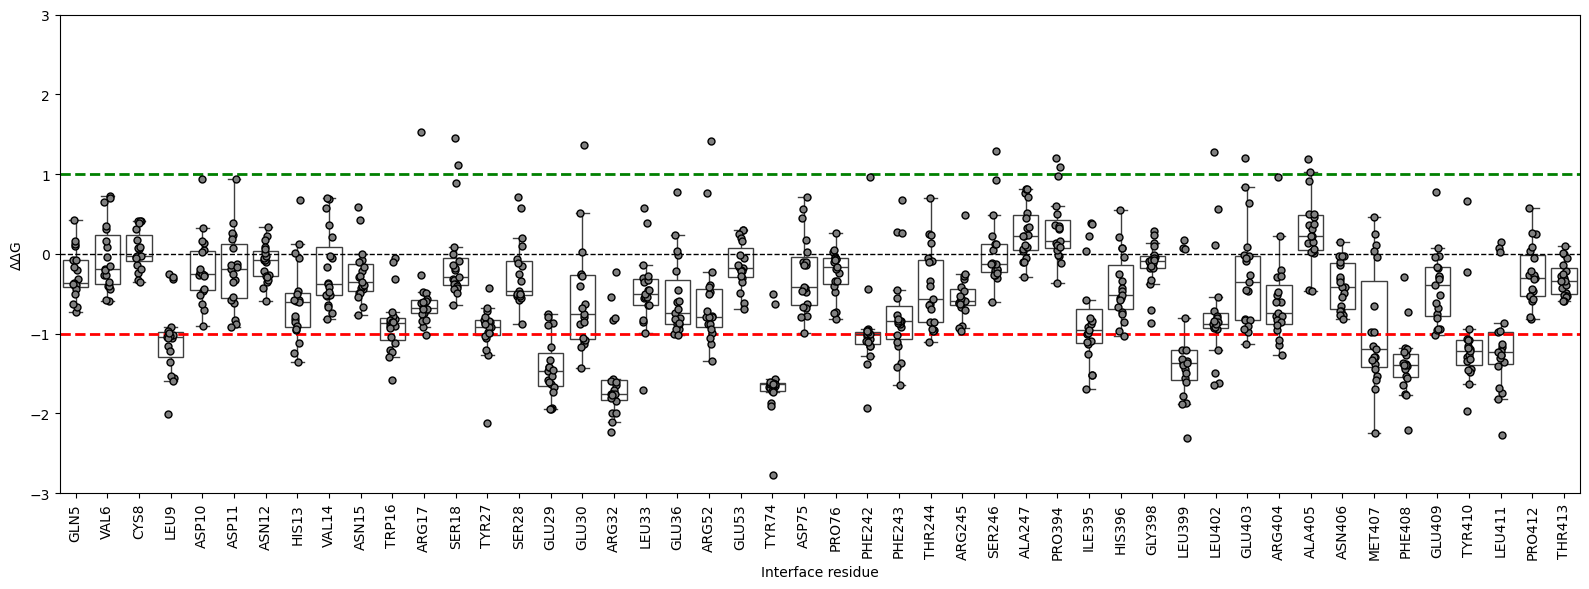

In [23]:
plot_boxplot_with_ddG(muts_df_C)#, "./saturation_mutagenesis_boxplot_FAM83G.png")

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_23245/2990196771.py:90: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("resnum", "mutant", "ddG")


<Figure size 9000x9000 with 0 Axes>

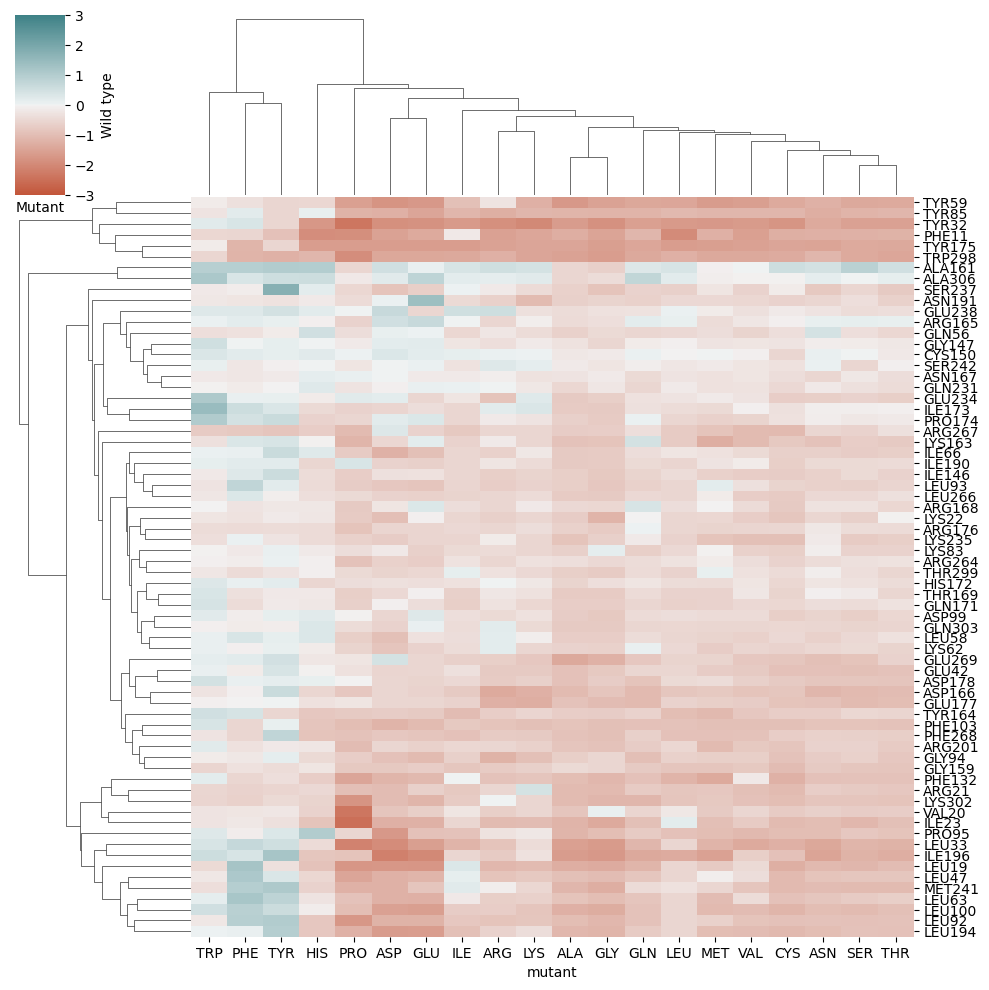

In [24]:
plot_clustermap(muts_df_D)#, "./saturation_mutagenesis_clustermap_CK1A.png")

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_23245/2990196771.py:90: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("resnum", "mutant", "ddG")


<Figure size 9000x9000 with 0 Axes>

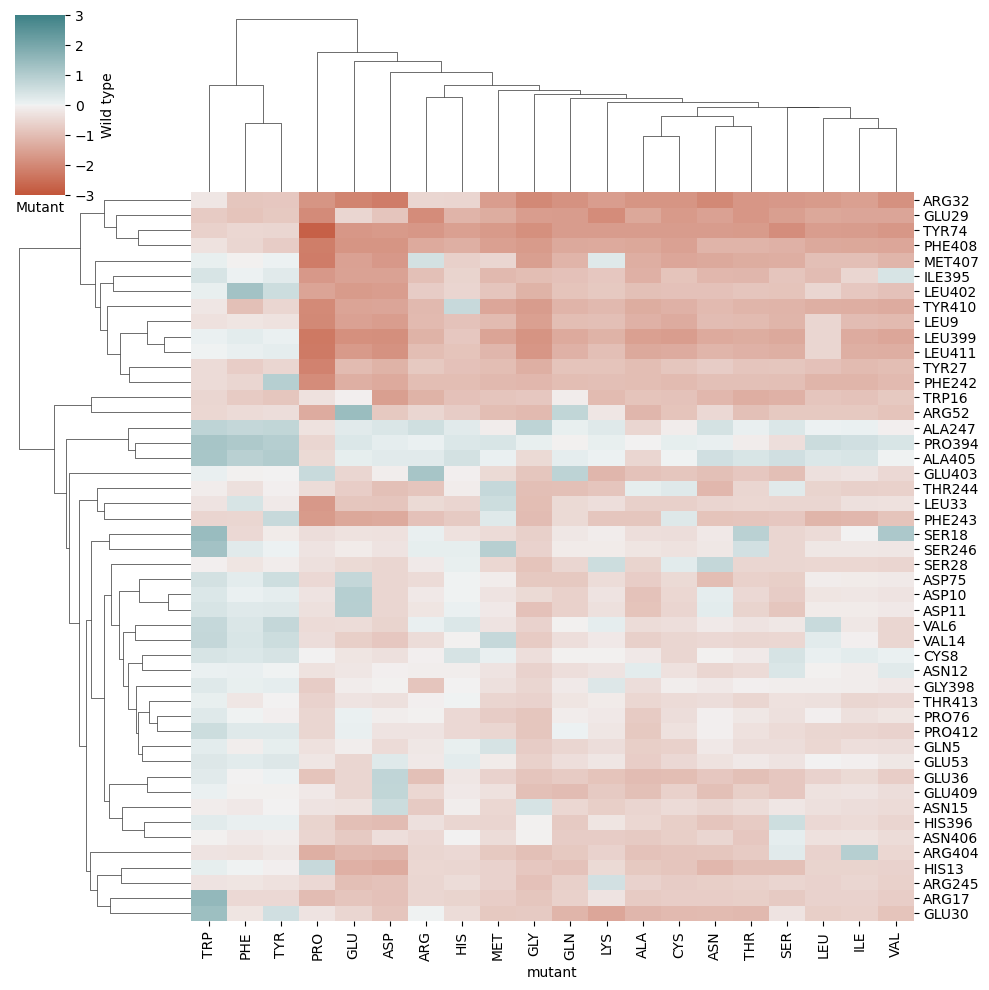

In [26]:
plot_clustermap(muts_df_C)#, "./saturation_mutagenesis_clustermap_FAM83G.png")

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_23245/2990196771.py:53: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("resnum", "mutant", "ddG")


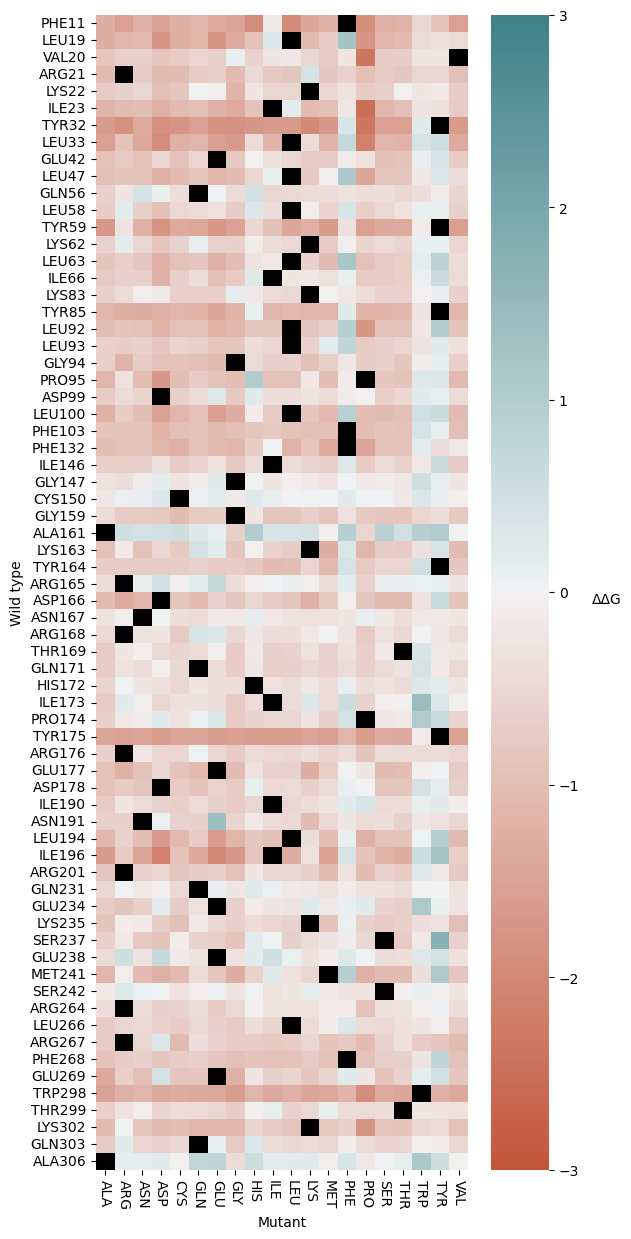

In [25]:
h = plot_heatmap(muts_df_D)#, "./saturation_mutagenesis_CK1A.png")

/var/folders/3s/nxmgkht57nz3bb6jhzrp5fhh0000gq/T/ipykernel_23245/2990196771.py:53: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("resnum", "mutant", "ddG")


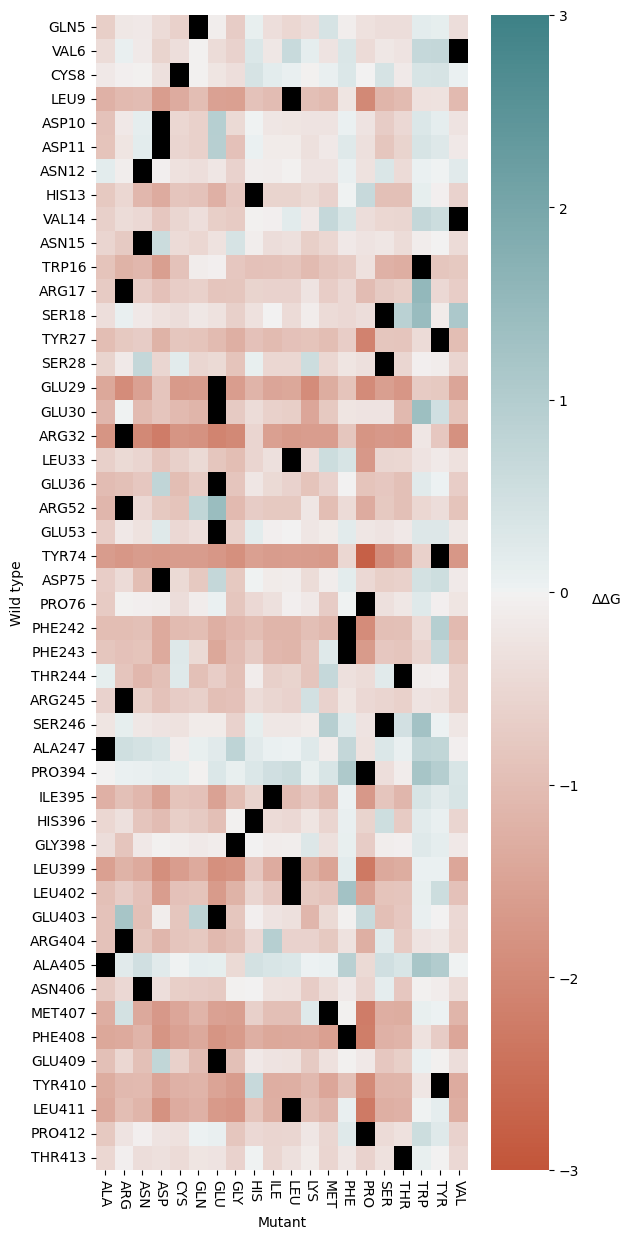

In [27]:
h = plot_heatmap(muts_df_C)#, "./saturation_mutagenesis_FAM83G.png")

## Splitting by ROI

In [28]:
ROI_1_FAM83G = [ #16
    "TYR27", "SER28", "GLU29", "GLU30", "ARG32",
    "LEU33", "GLU36", "ARG52", "GLU53", "TYR74",
    "PHE242", "PHE243", "THR244", "ARG245", "SER246",
    "ALA247"
]

ROI_1_CK1A = [ #19
    "ARG176", "GLU177", "ASP178", "ILE190", "ASN191",
    "LEU194", "ILE196", "ARG201", "GLU234", "LYS235",
    "SER237", "GLU238", "MET241", "SER242", "ARG264",
    "LEU266", "ARG267", "PHE268", "GLU269"
]

ROI_2_FAM83G = [ #14
    "MET1", "ALA2", "GLN5", "VAL6", "CYS8",
    "LEU9", "ASP10", "ASP11", "HIS13", "VAL14",
    "ASN15", "TRP16", "ARG17", "SER18"
]

ROI_2_CK1A = [ #23
    "PRO55", "GLN56", "LEU58", "TYR59", "LYS62",
    "LEU63", "ILE66", "PHE132", "ARG135", "GLY159",
    "LEU160", "ALA161", "LYS163", "TYR164", "ARG165",
    "ASP166", "ASN167", "THR169", "GLN171", "HIS172",
    "ILE173", "PRO174", "TYR175" 
]

ROI_3_FAM83G = [ #17
    "ILE395", "HIS396", "GLY398", "LEU399", "LEU402",
    "GLU403", "ARG404", "ALA405", "ASN406", "MET407",
    "PHE408", "GLU409", "TYR410", "LEU411", "PRO412",
    "THR413", "TRP414" 
]

ROI_3_CK1A = [ #29
    "GLU10", "PHE11", "LEU19", "VAL20", "LYS22",
    "ILE23", "TYR32", "LEU33", "LEU47", "LYS83",
    "TYR85", "LEU92", "LEU93", "GLY94", "PRO95",
    "ASP99", "LEU100", "PHE103", "MET144", "GLY145",
    "ILE146", "GLY147", "CYS150", "TRP298", "THR299",
    "LYS302", "GLN303", "ALA306", "GLN307" 
]

In [29]:
muts_df_C["mean_ddg"] = muts_df_C["reslabel"].map(muts_df_C.groupby("reslabel")["ddG"].mean().round(4))
muts_df_D["mean_ddg"] = muts_df_D["reslabel"].map(muts_df_D.groupby("reslabel")["ddG"].mean().round(4))

muts_df_C["median_ddg"] = muts_df_C["reslabel"].map(muts_df_C.groupby("reslabel")["ddG"].median().round(4))
muts_df_D["median_ddg"] = muts_df_D["reslabel"].map(muts_df_D.groupby("reslabel")["ddG"].median().round(4))

muts_df_C["resname2"] = muts_df_C.resname + muts_df_C.resnum.astype(str)
muts_df_D["resname2"] = muts_df_D.resname + muts_df_D.resnum.astype(str)

In [30]:
unique_FAM83G_ress = muts_df_C[["reslabel", "resname2", "dist", "median_ddg"]].drop_duplicates().sort_values(by = "median_ddg").round(2).reset_index(drop = True)
unique_FAM83G_ress["rank"] = unique_FAM83G_ress.index + 1

In [31]:
unique_CK1A_ress = muts_df_D[["reslabel", "resname2", "dist", "median_ddg"]].drop_duplicates().sort_values(by = "median_ddg").round(2).reset_index(drop = True)
unique_CK1A_ress["rank"] = unique_CK1A_ress.index + 1

In [38]:
unique_FAM83G_ress.query('reslabel in @ROI_1_FAM83G')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/FAM83G_ROI_1.csv", index = False)
unique_FAM83G_ress.query('reslabel in @ROI_2_FAM83G')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/FAM83G_ROI_2.csv", index = False)
unique_FAM83G_ress.query('reslabel in @ROI_3_FAM83G')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/FAM83G_ROI_3.csv", index = False)

unique_CK1A_ress.query('reslabel in @ROI_1_CK1A')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/CK1A_ROI_1.csv", index = False)
unique_CK1A_ress.query('reslabel in @ROI_2_CK1A')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/CK1A_ROI_2.csv", index = False)
unique_CK1A_ress.query('reslabel in @ROI_3_CK1A')[["rank", "resname2", "dist", "median_ddg"]].to_csv("./csv/CK1A_ROI_3.csv", index = False)

## FAM83G interfaces

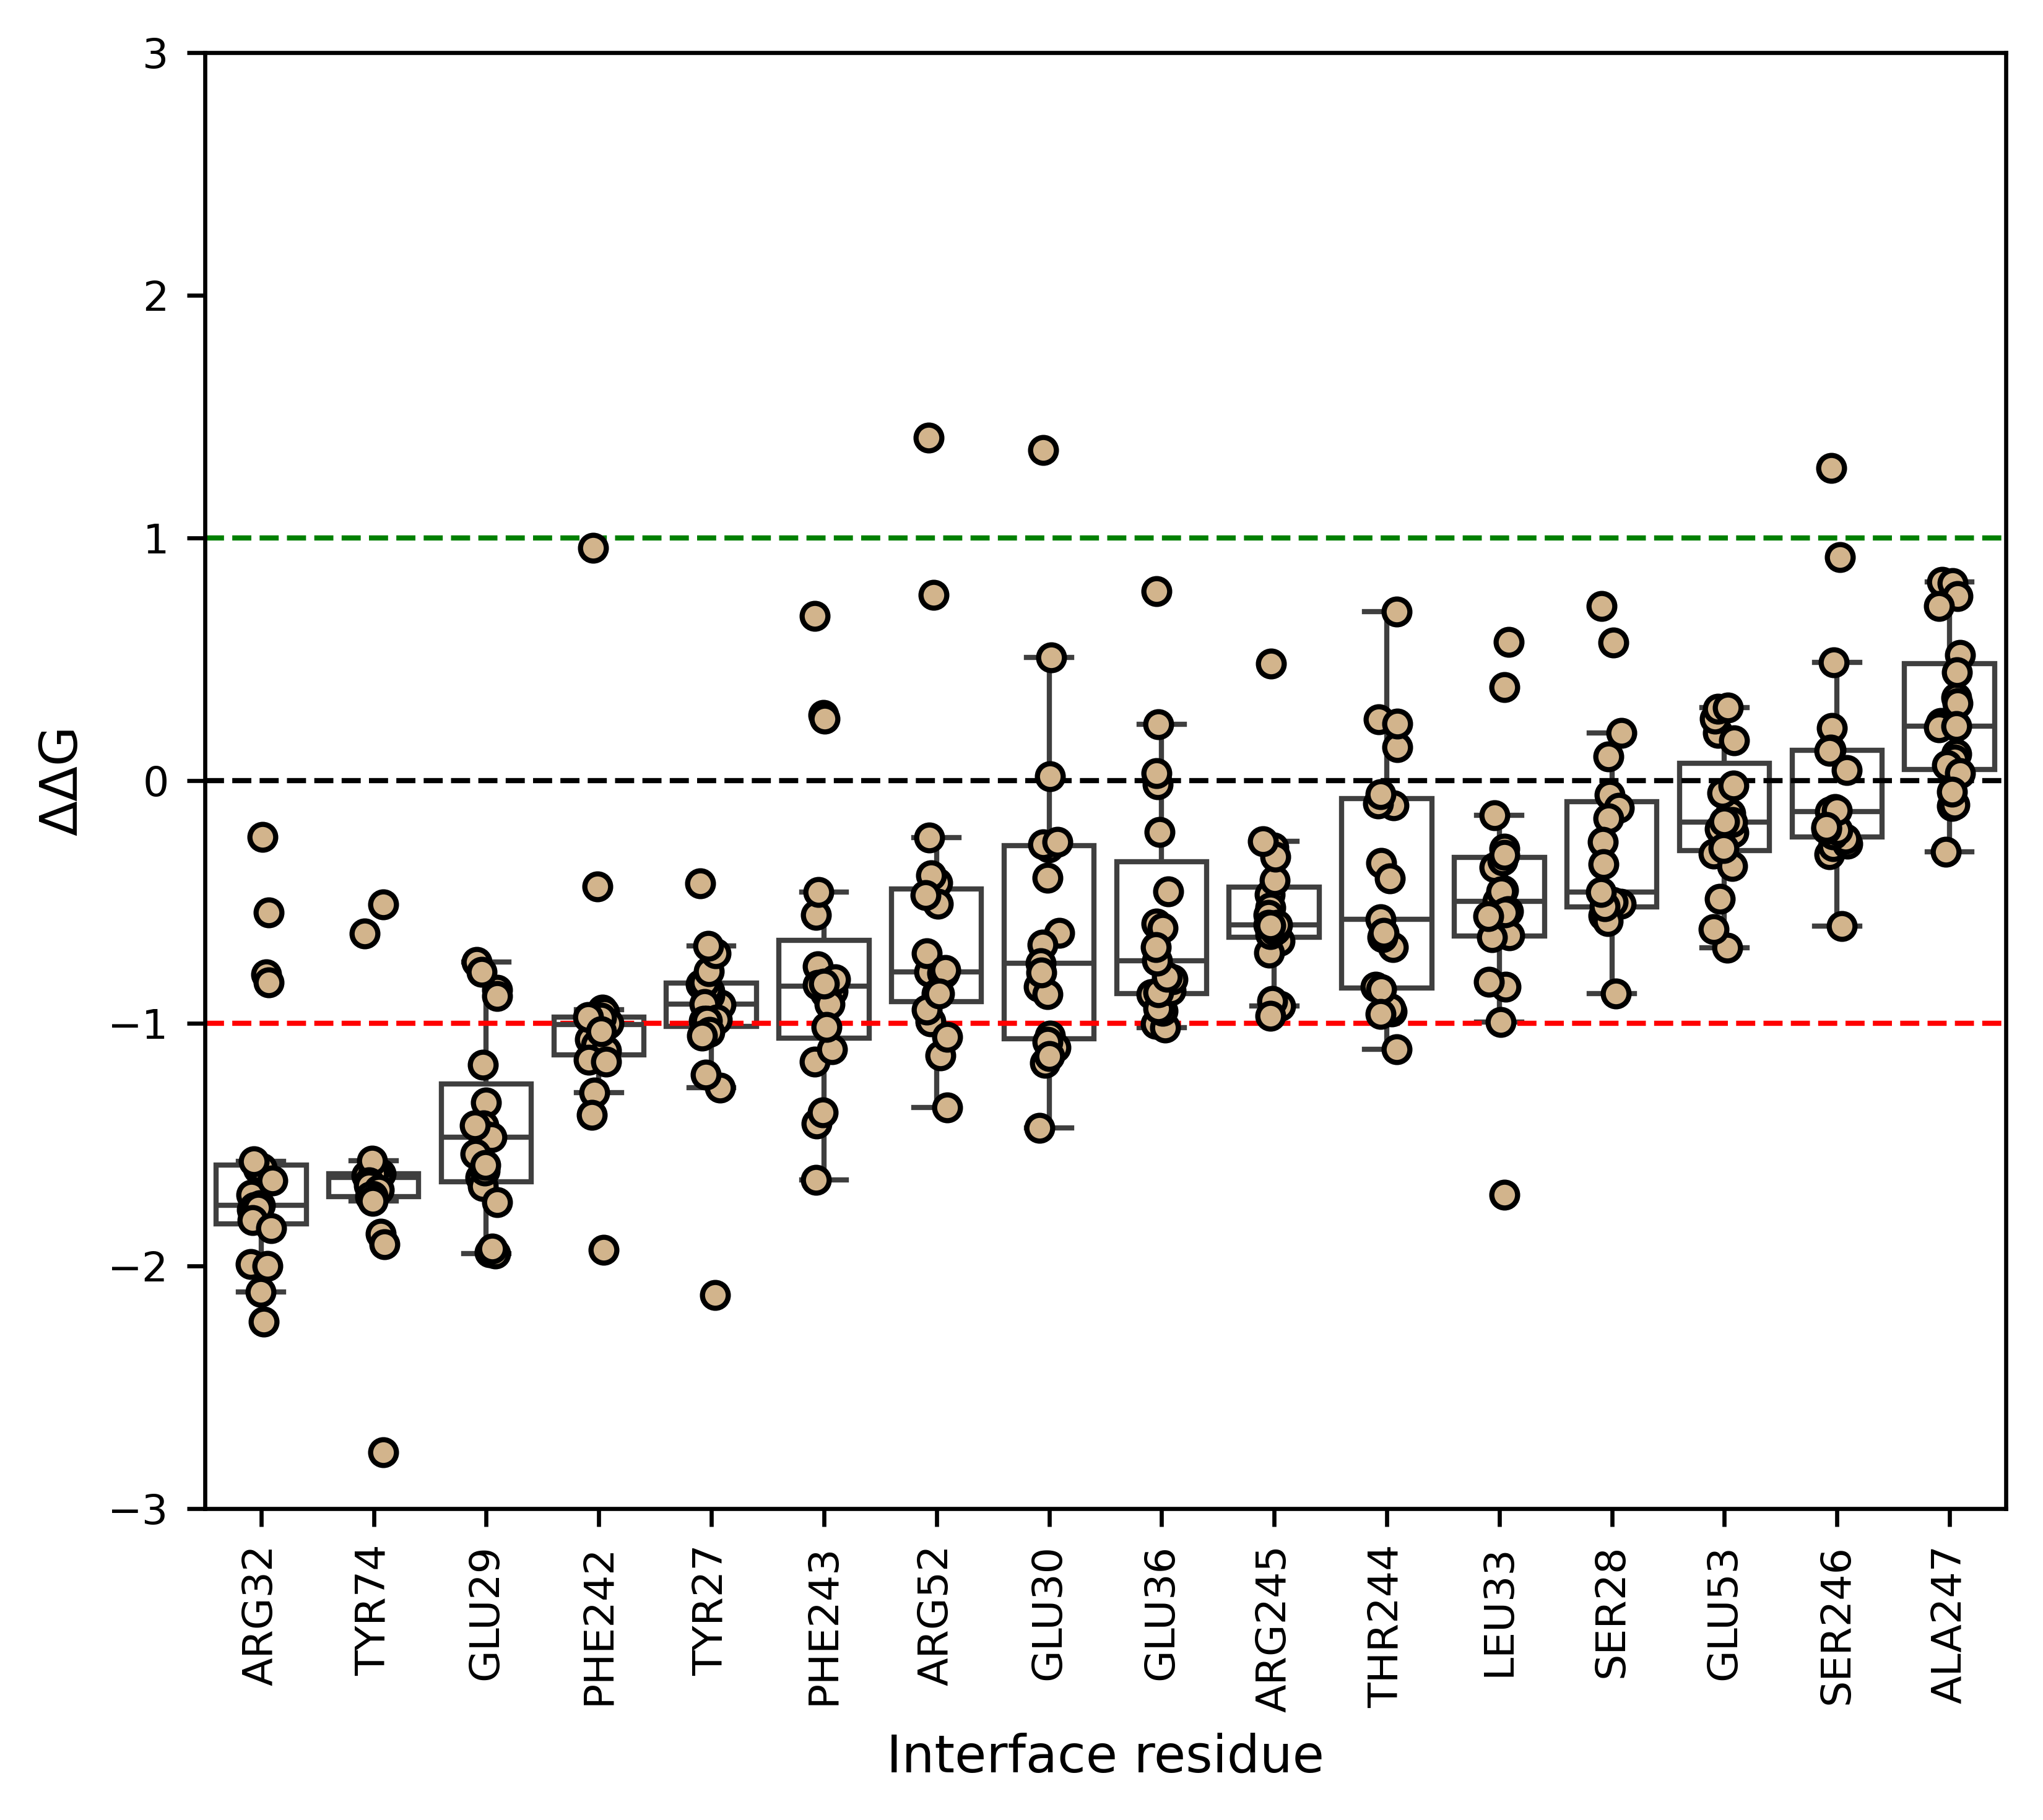

In [51]:
plot_boxplot_with_ddG(muts_df_C.query('reslabel in @ROI_1_FAM83G'), FIGSIZE = (5.6, 5), DPI = 600, color = "tan",
                      out =  "./png/FAM83G_ROI1.png")

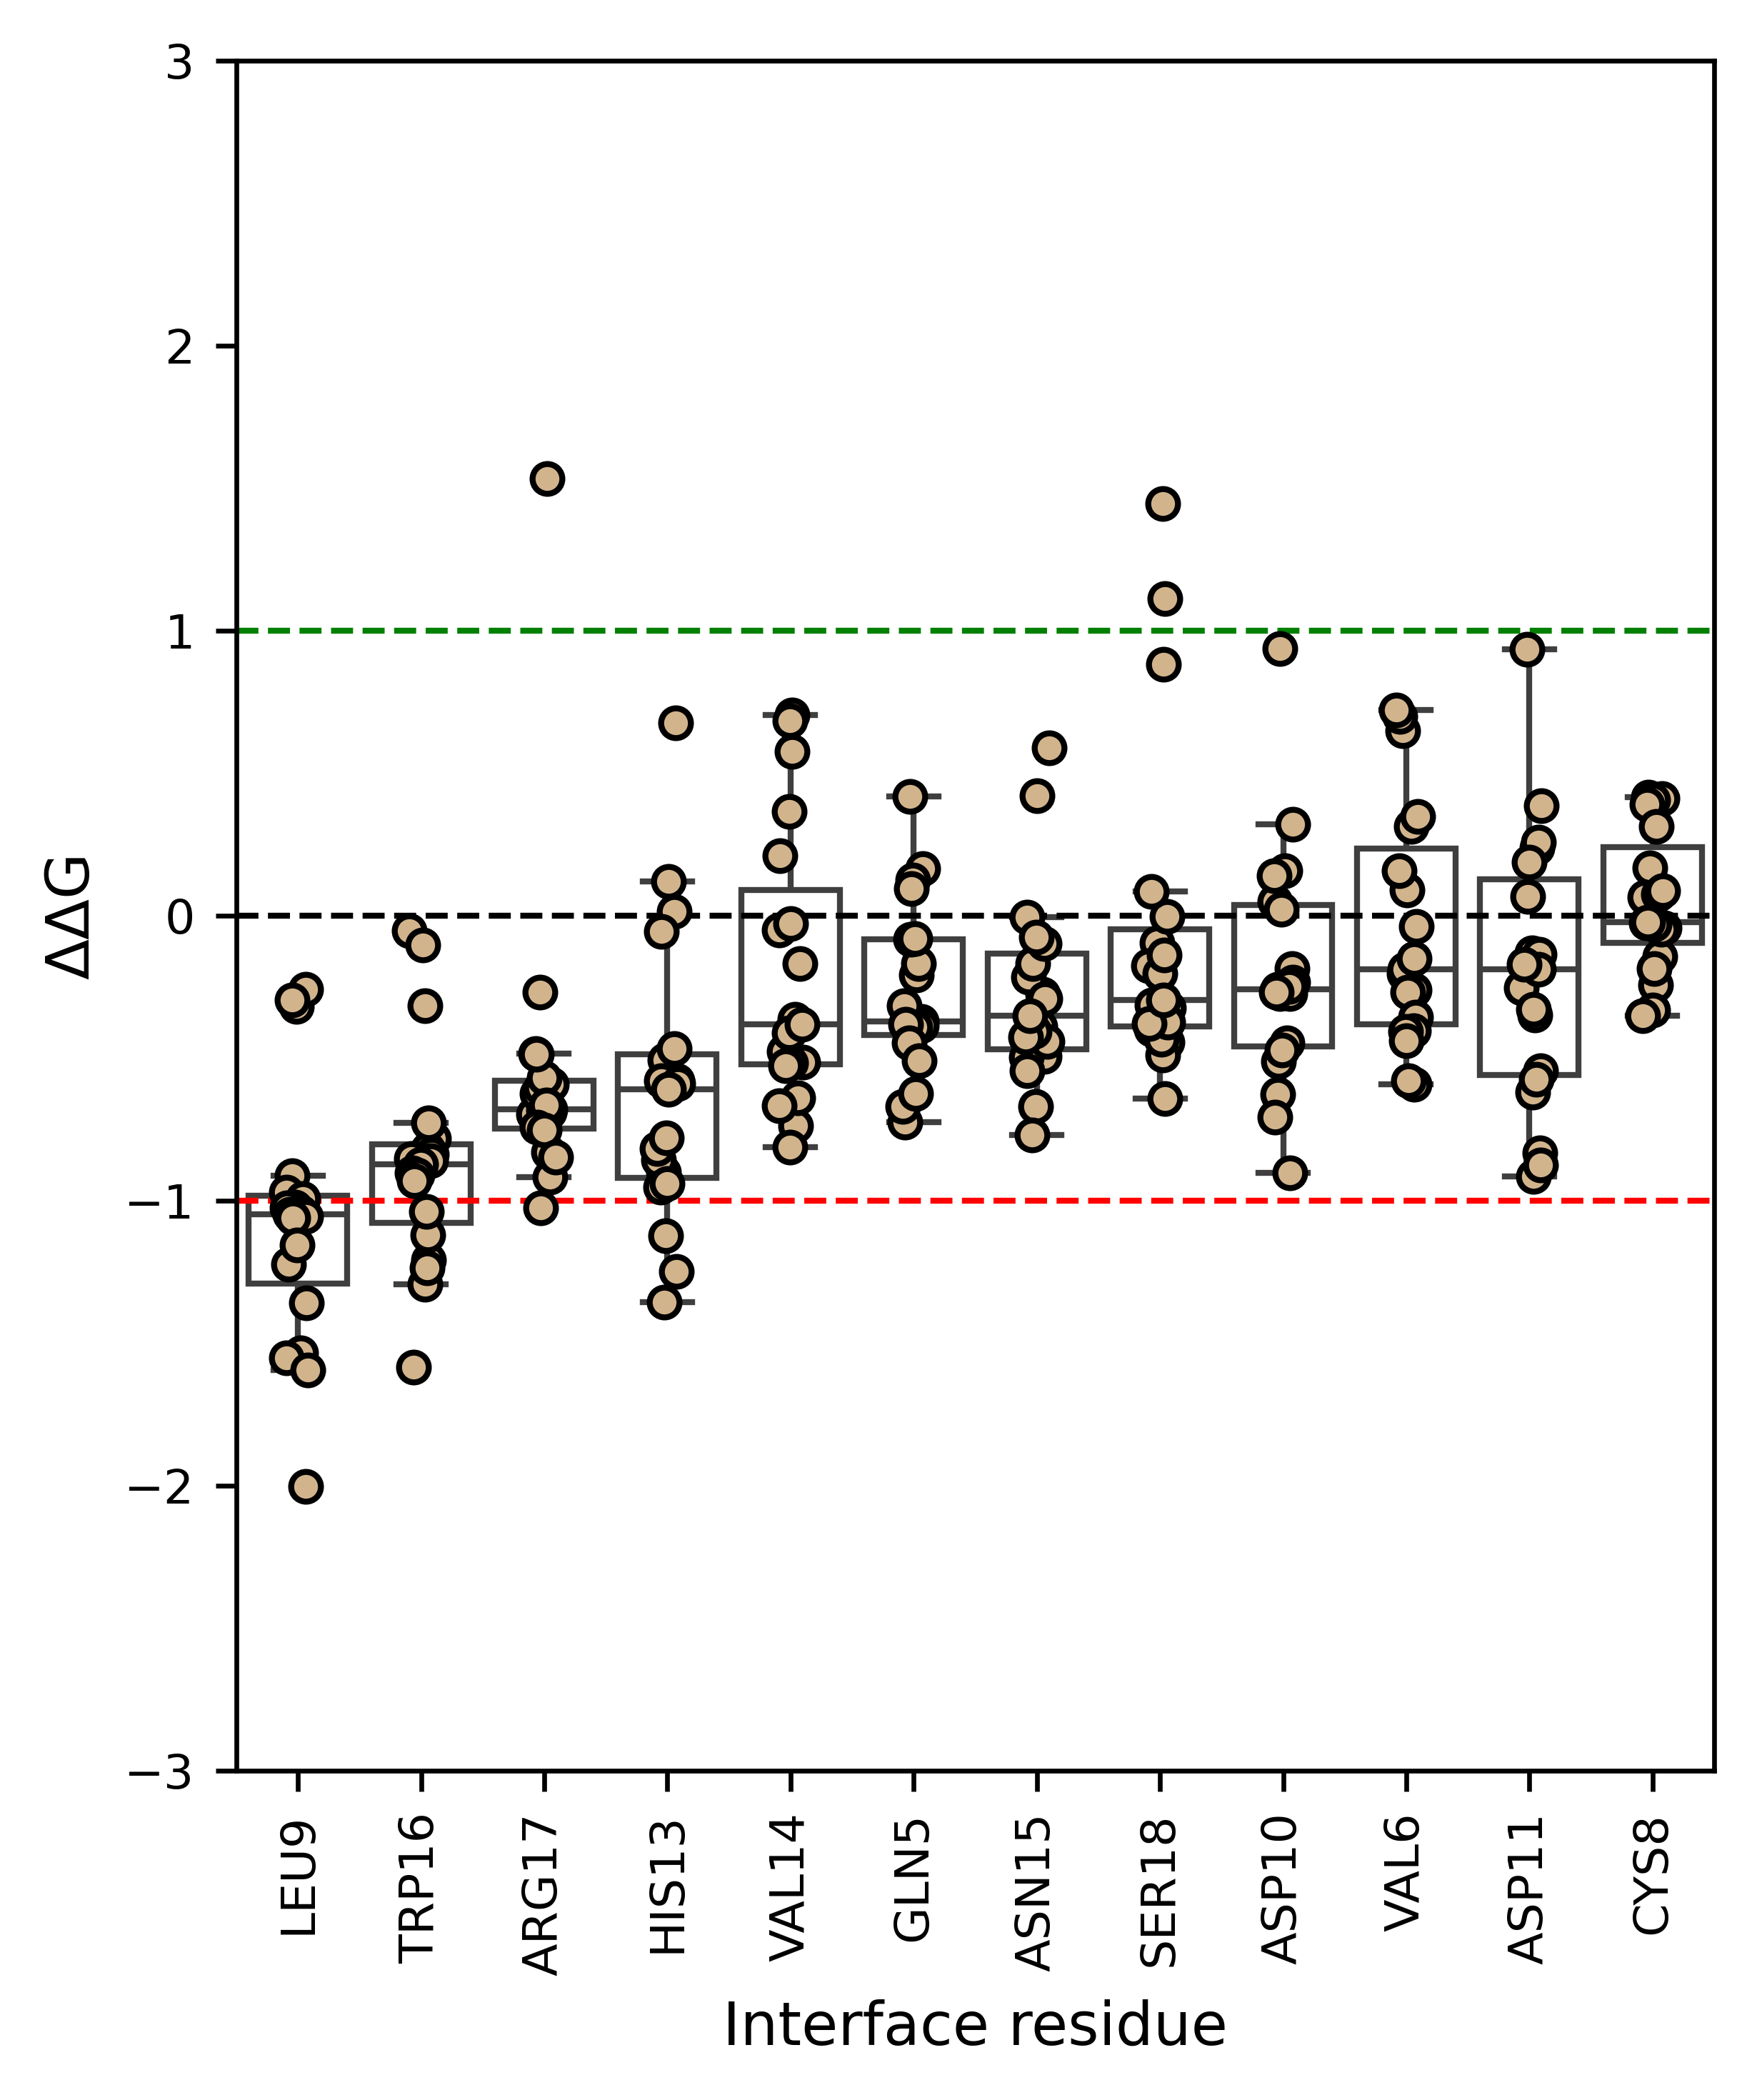

In [52]:
plot_boxplot_with_ddG(muts_df_C.query('reslabel in @ROI_2_FAM83G'), FIGSIZE = (4.2, 5), DPI = 600, color = "tan",
                      out =  "./png/FAM83G_ROI2.png")

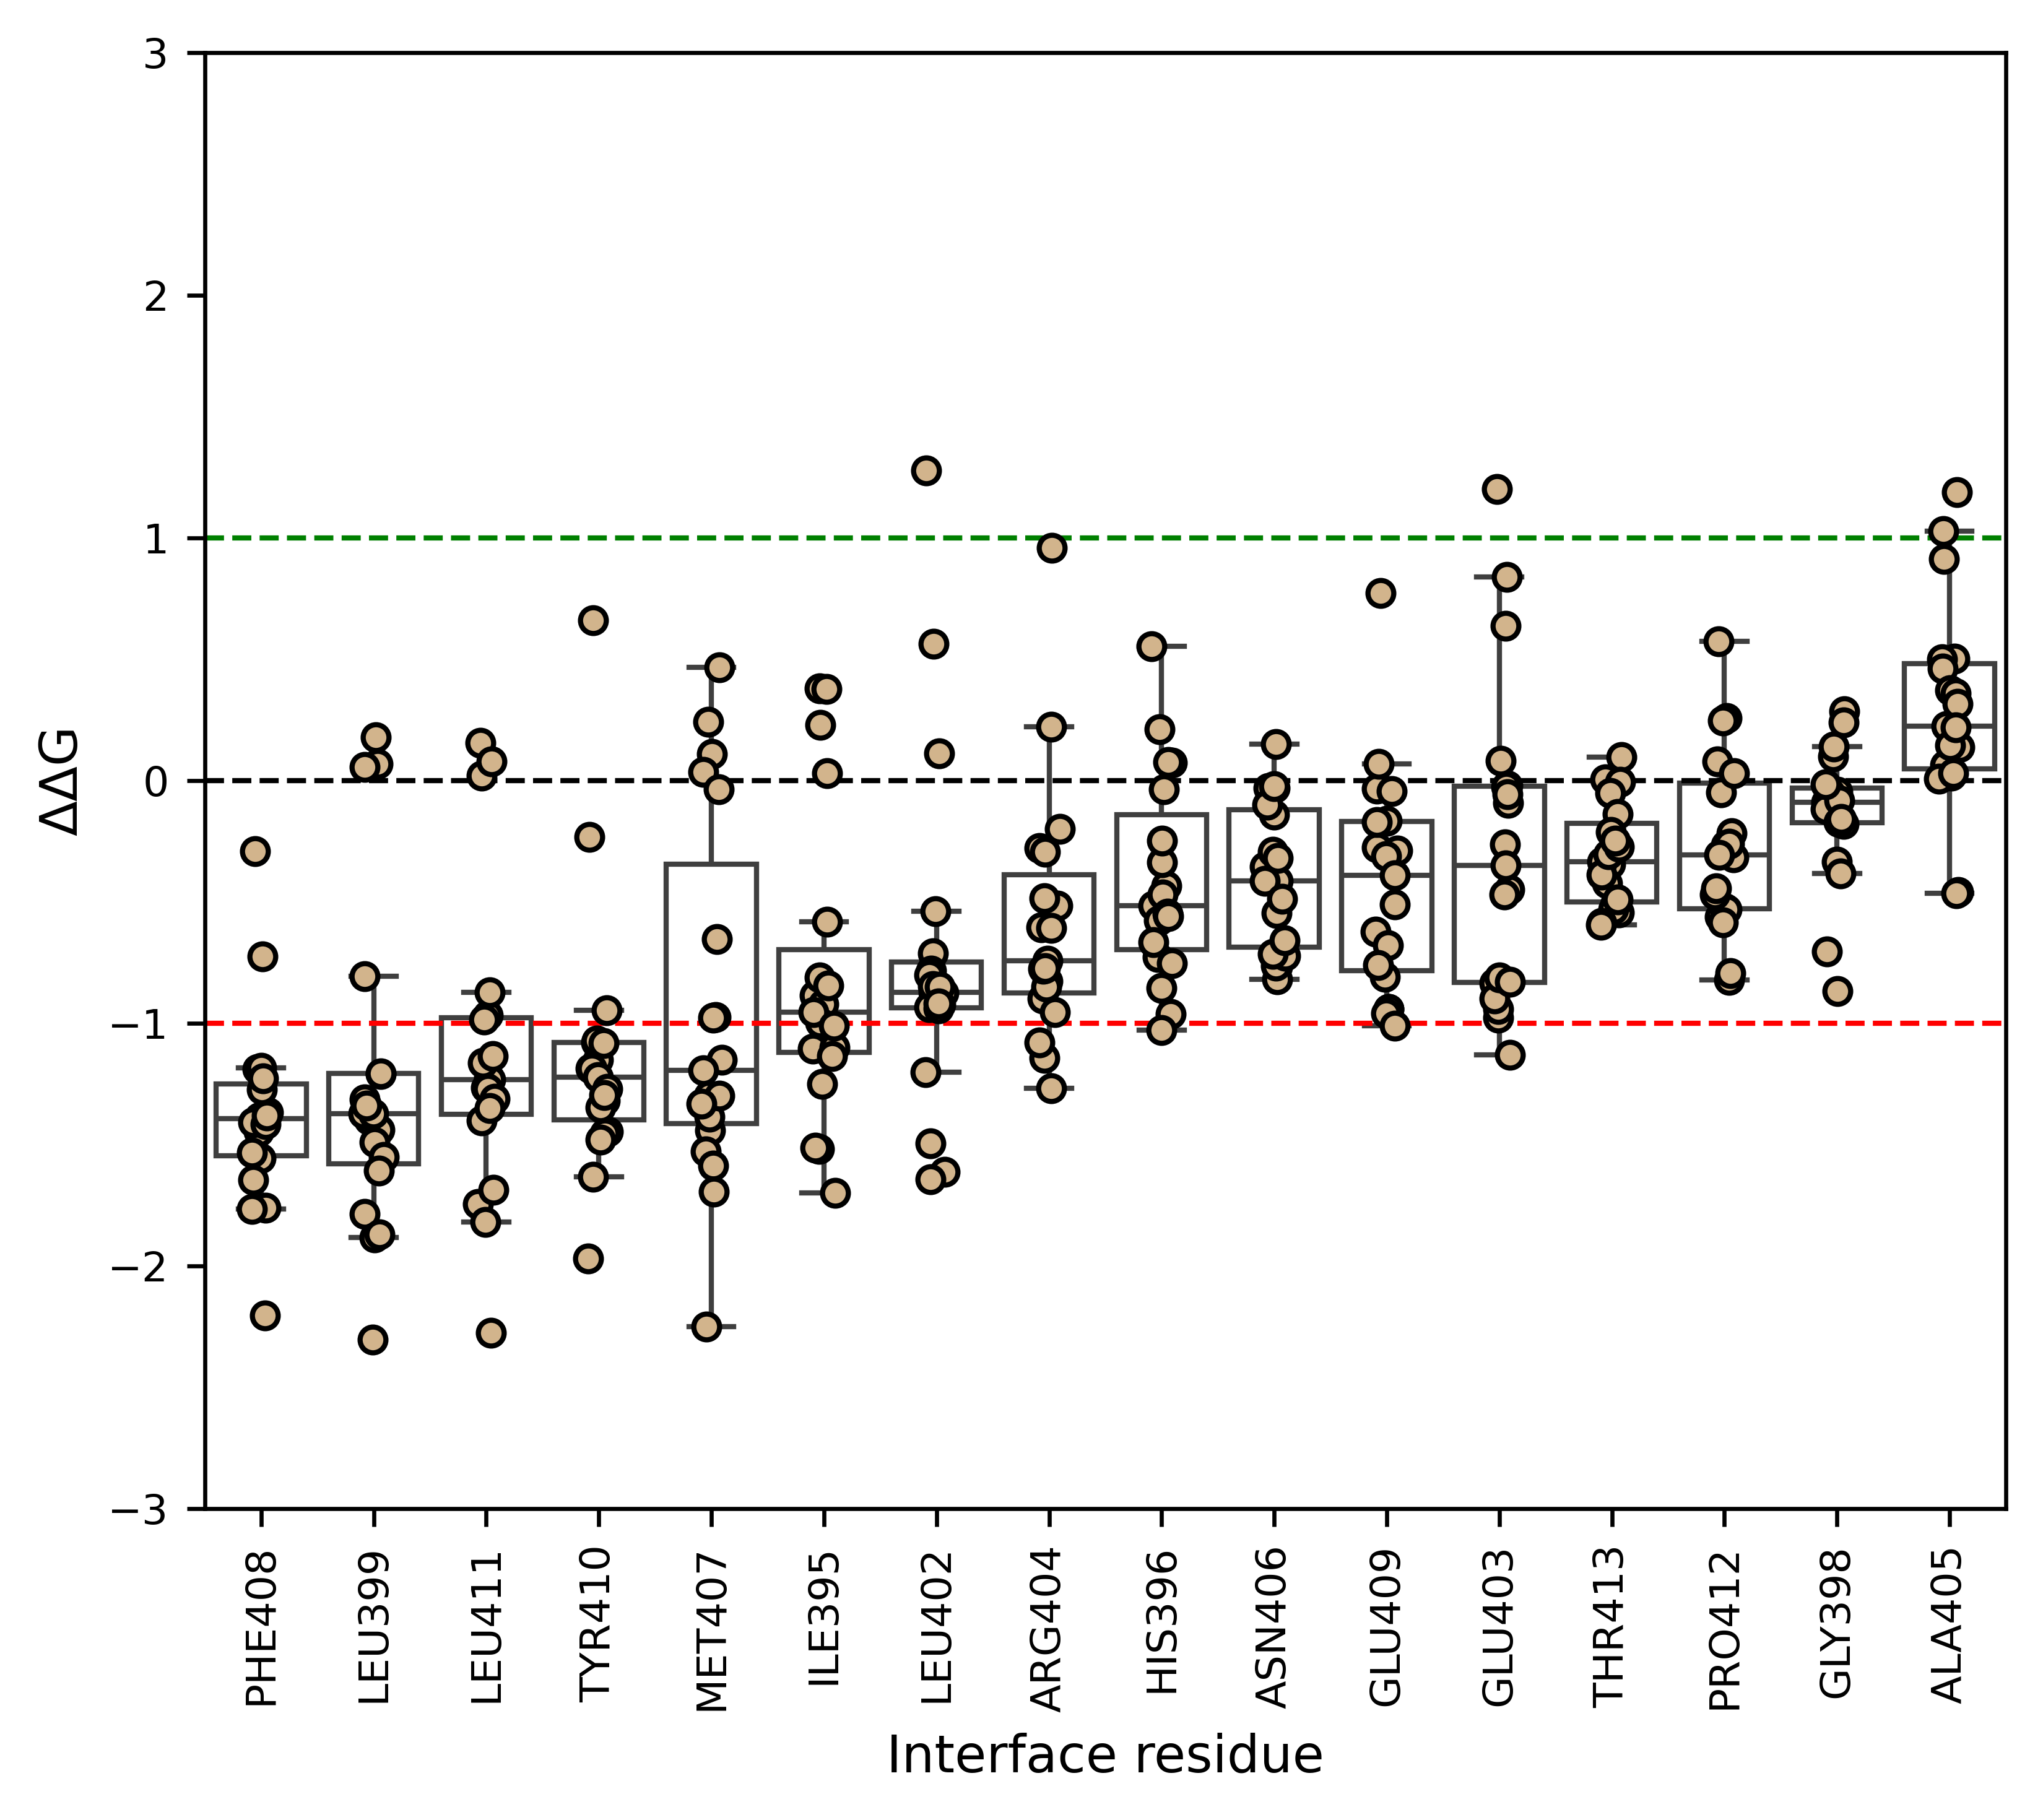

In [53]:
plot_boxplot_with_ddG(muts_df_C.query('reslabel in @ROI_3_FAM83G'), FIGSIZE = (5.6, 5), DPI = 600, color = "tan",
                      out =  "./png/FAM83G_ROI3.png")

## CK1A interfaces

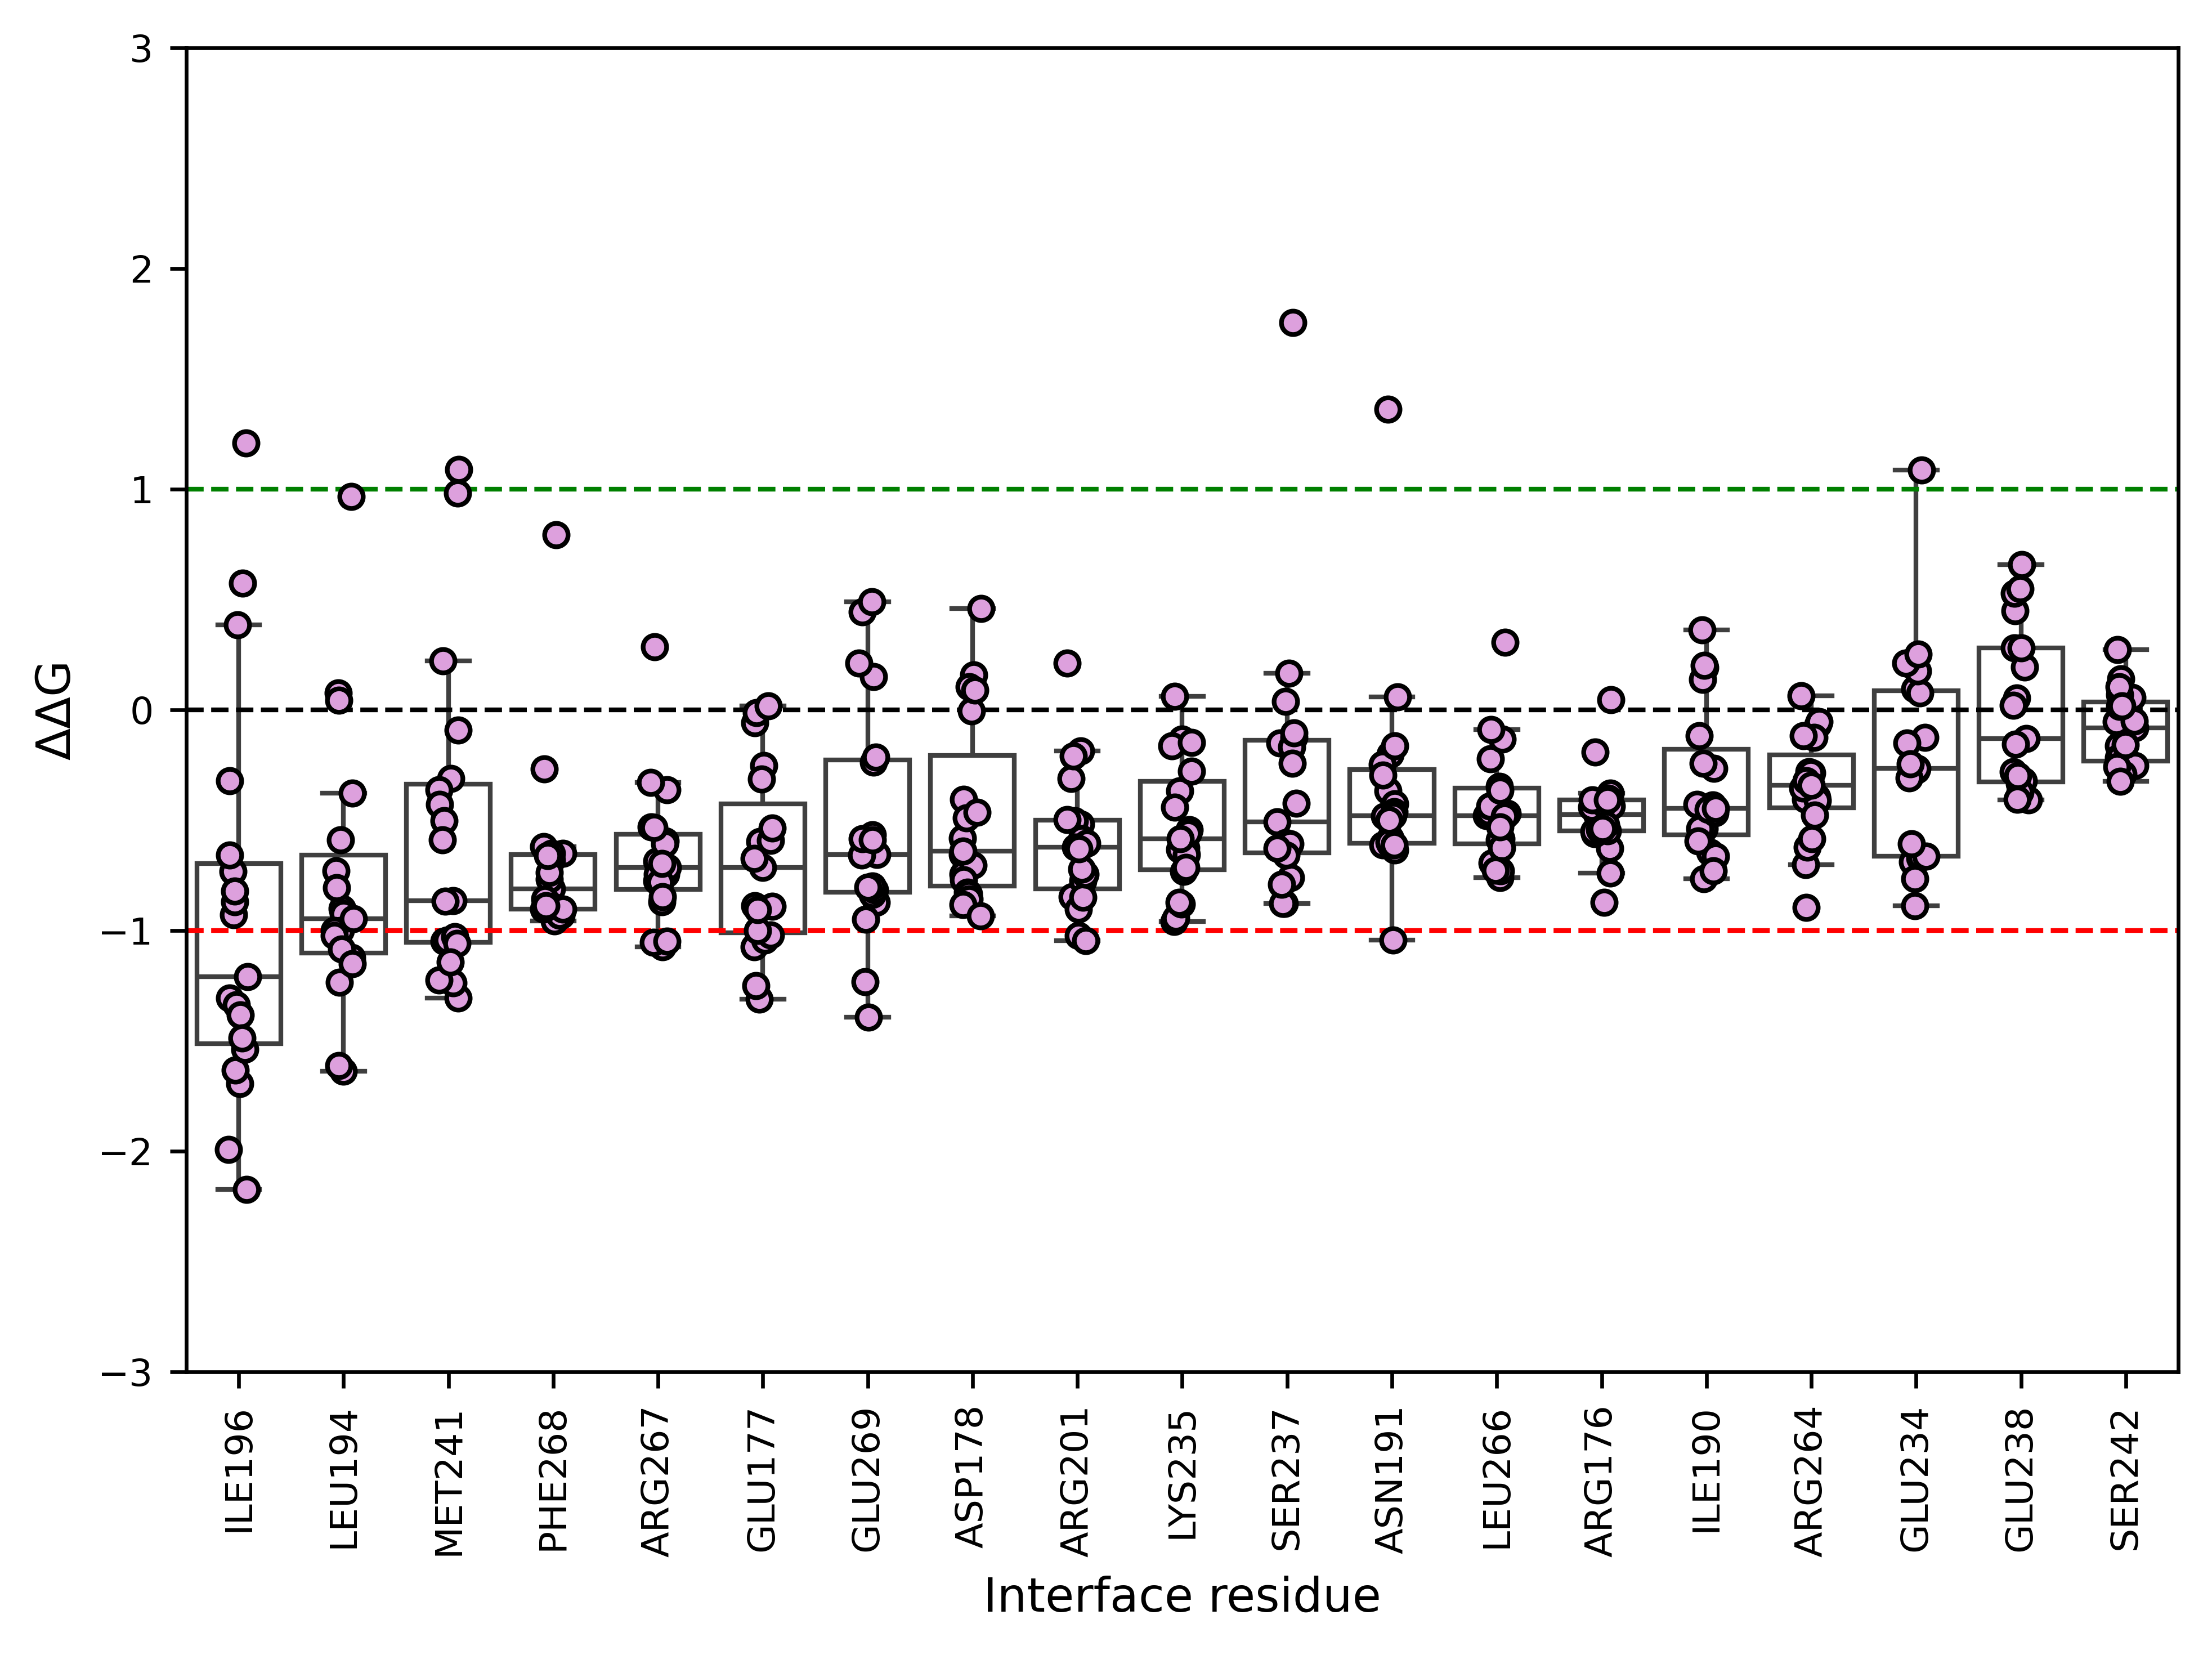

In [54]:
plot_boxplot_with_ddG(muts_df_D.query('reslabel in @ROI_1_CK1A'), FIGSIZE = (6.65, 5), DPI = 600, color = "plum",
                      out =  "./png/CK1A_ROI1.png")

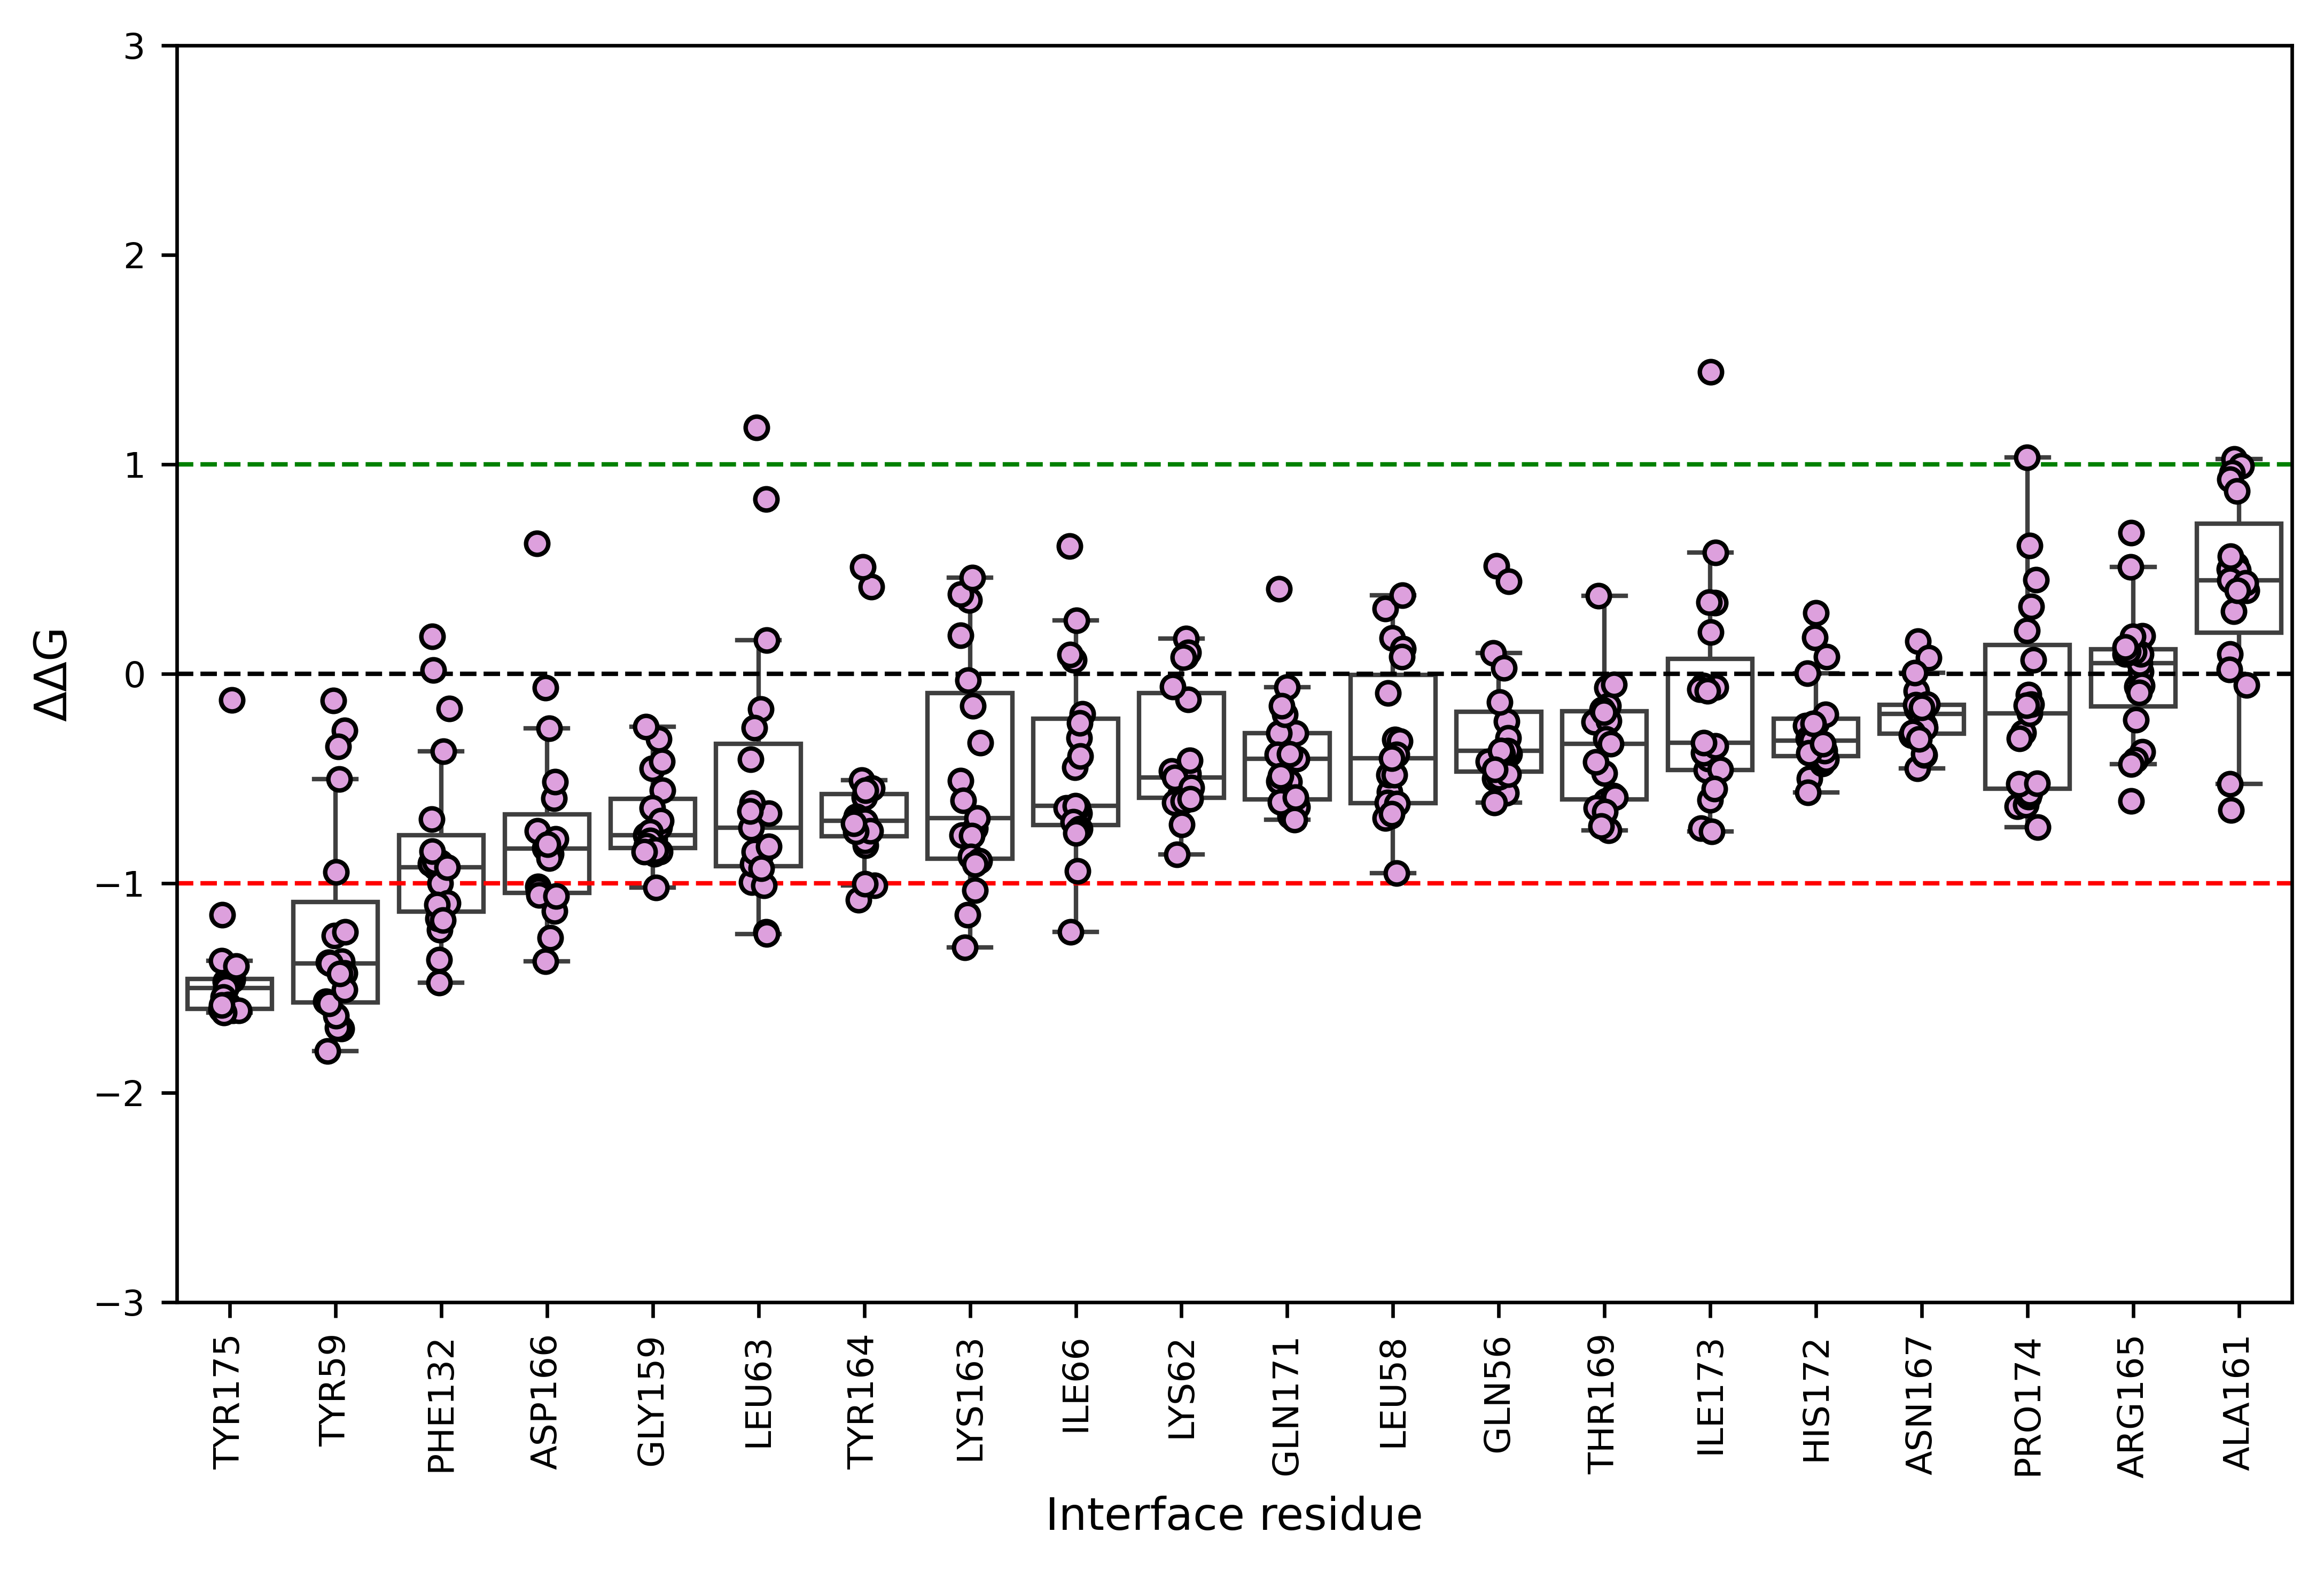

In [55]:
plot_boxplot_with_ddG(muts_df_D.query('reslabel in @ROI_2_CK1A'), FIGSIZE = (7.35, 5), DPI = 600, color = "plum",
                      out =  "./png/CK1A_ROI2.png")

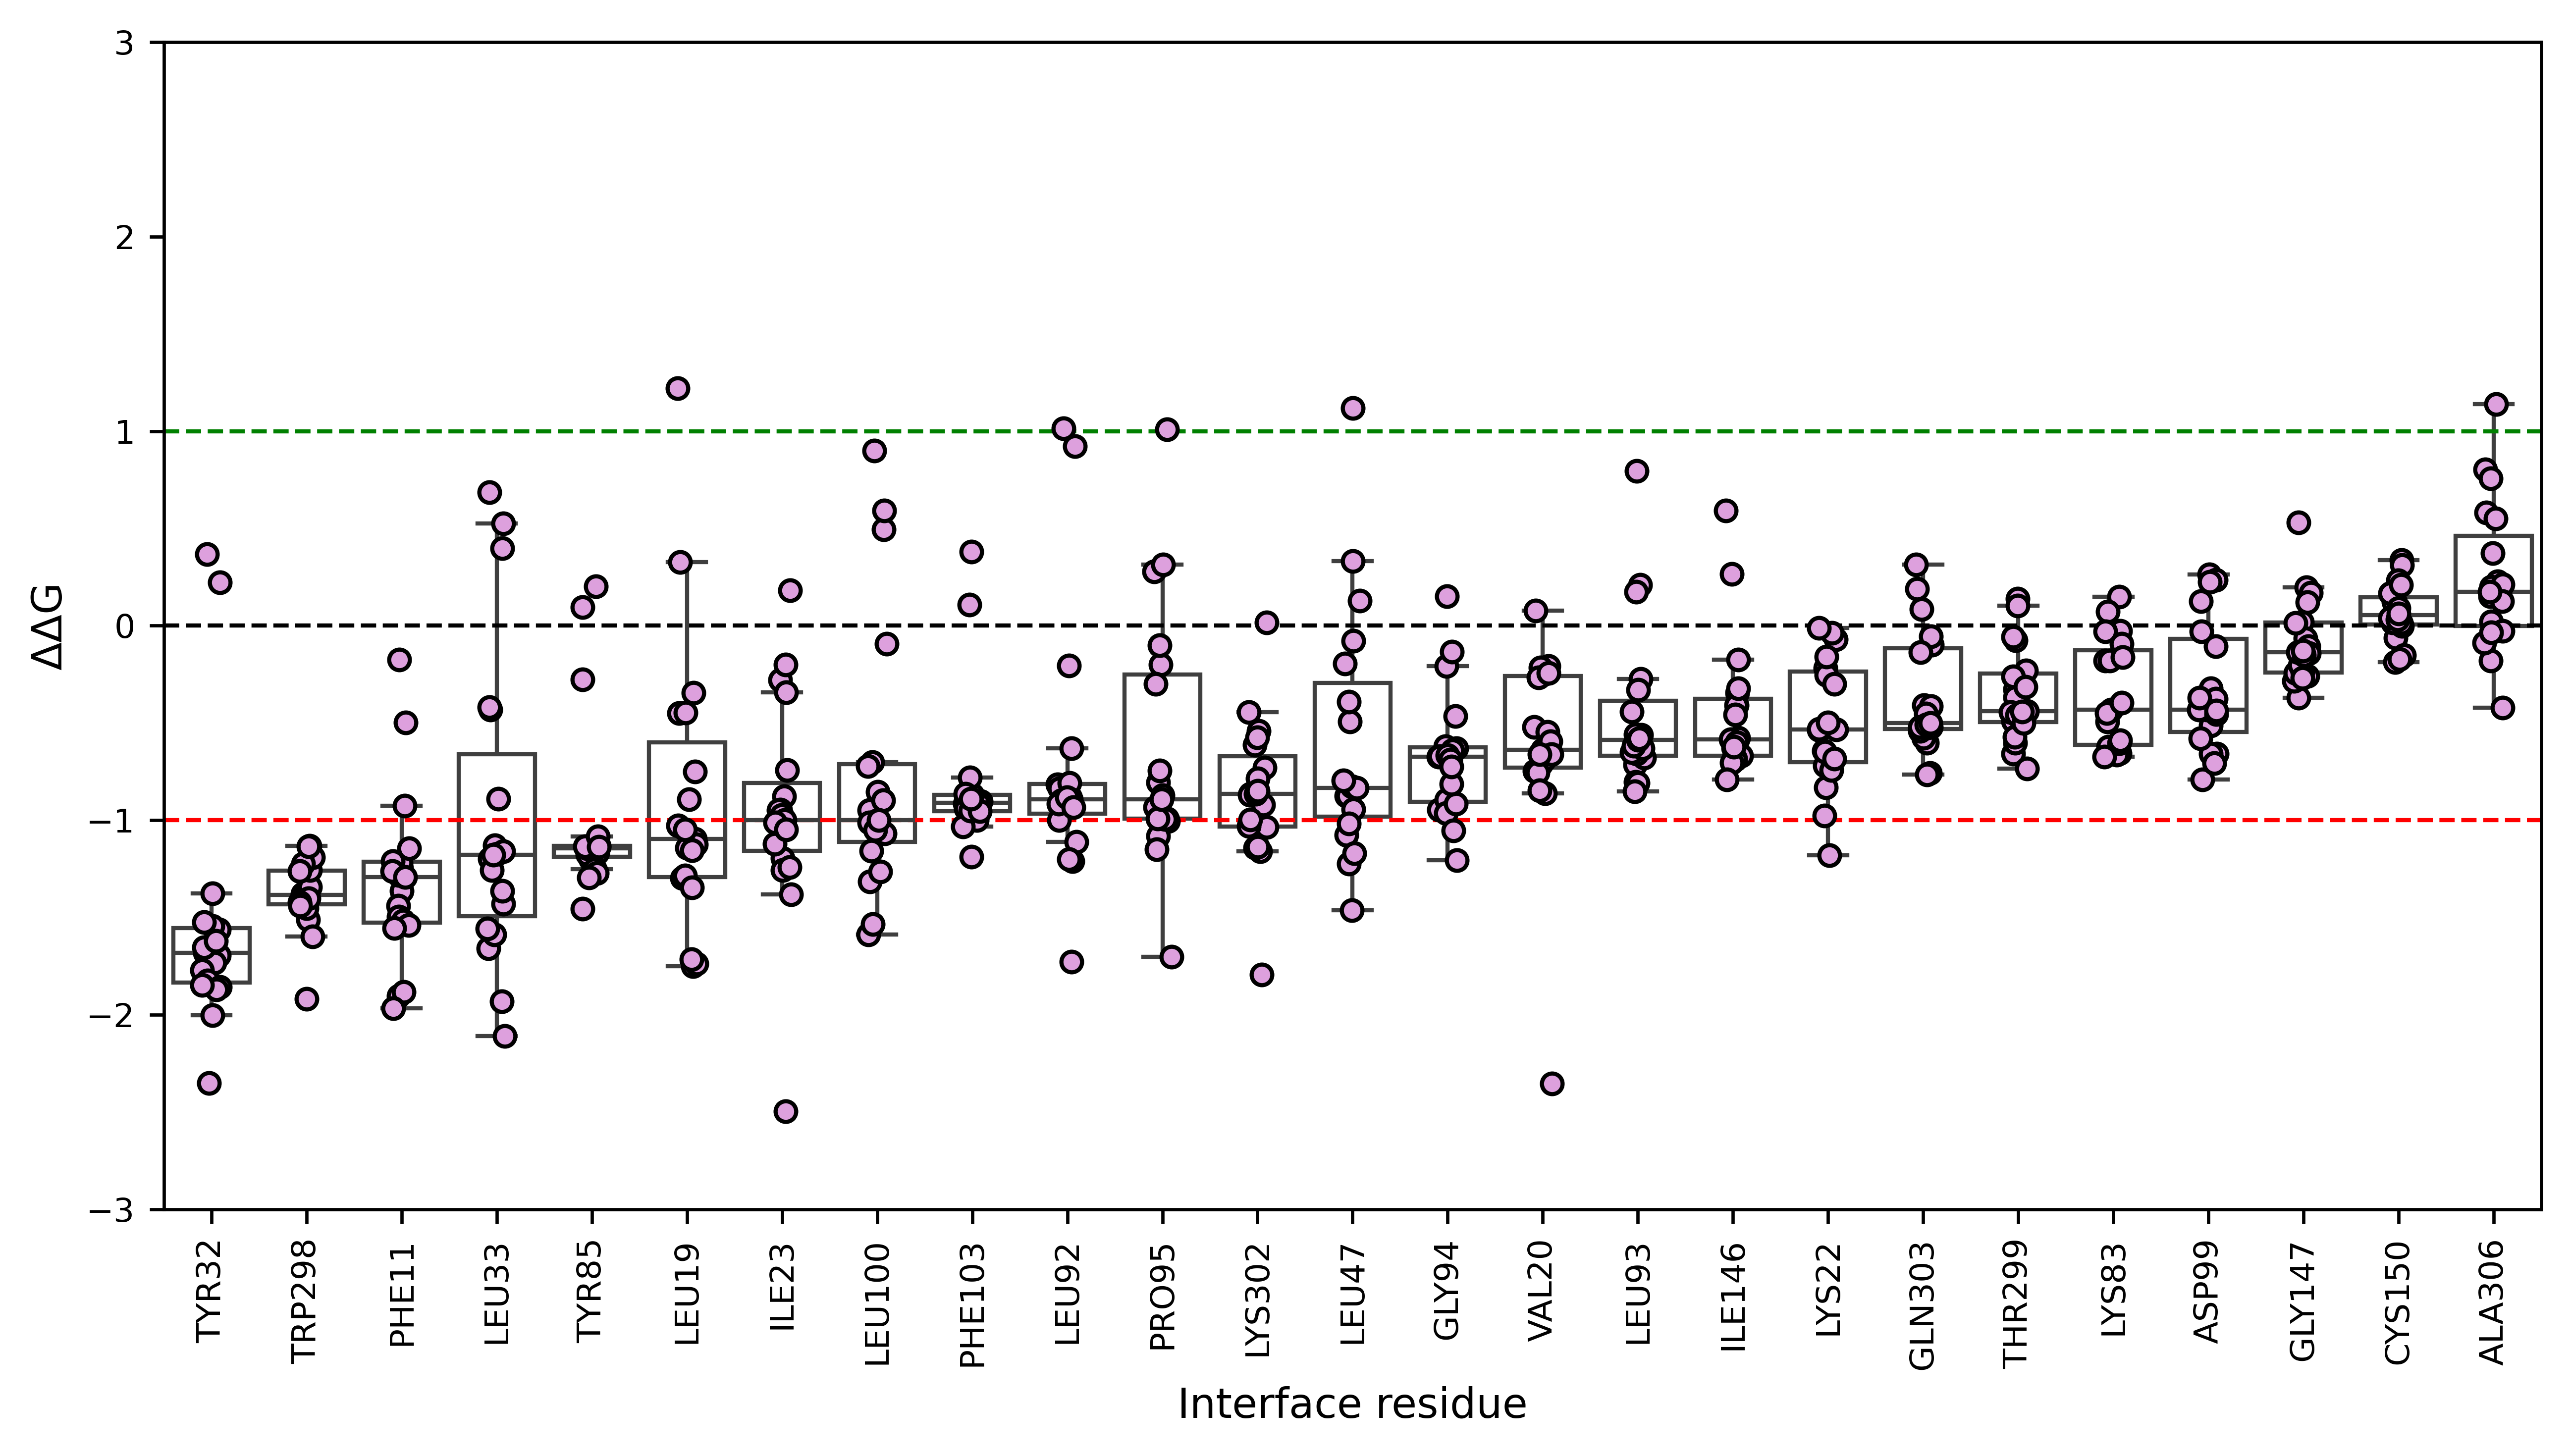

In [56]:
plot_boxplot_with_ddG(muts_df_D.query('reslabel in @ROI_3_CK1A'), FIGSIZE = (8.75, 5), DPI = 600, color = "plum",
                      out =  "./png/CK1A_ROI3.png")